In [1]:
!pip install lightfm

     |████████████████████████████████| 310 kB 5.1 MB/s eta 0:00:01
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705365 sha256=c723304f9857d43bacc44940084adbf0efd9a8bb72ec2ac8c0a519d756ffe4df
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [2]:
import numpy as np
import pandas as pd
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k
from lightfm.datasets import fetch_movielens

from flask import Flask, jsonify, request

In [3]:
movielens = fetch_movielens()
train, test = movielens['train'], movielens['test']

In [4]:
train.todense()

matrix([[5, 3, 4, ..., 0, 0, 0],
        [4, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [5, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 5, 0, ..., 0, 0, 0]], dtype=int32)

In [5]:
alpha = 1e-05
epochs = 70
num_components = 32

In [6]:
warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha)

In [7]:
bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

In [8]:
logistic_model = LightFM(no_components=num_components,
                    loss='logistic',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

In [9]:
warp_duration = []
bpr_duration = []
logistic_duration = []
warp_auc = []
bpr_auc = []
logistic_auc = []

In [10]:
for epoch in range(epochs):
    start = time.time()
    warp_model.fit_partial(train, epochs=1)
    warp_duration.append(time.time() - start)
    warp_auc.append(auc_score(warp_model, test, train_interactions=train).mean())

for epoch in range(epochs):
    start = time.time()
    bpr_model.fit_partial(train, epochs=1)
    bpr_duration.append(time.time() - start)
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())
    
for epoch in range(epochs):
    start = time.time()
    logistic_model.fit_partial(train, epochs=1)
    logistic_duration.append(time.time() - start)
    logistic_auc.append(auc_score(bpr_model, test, train_interactions=train).mean())

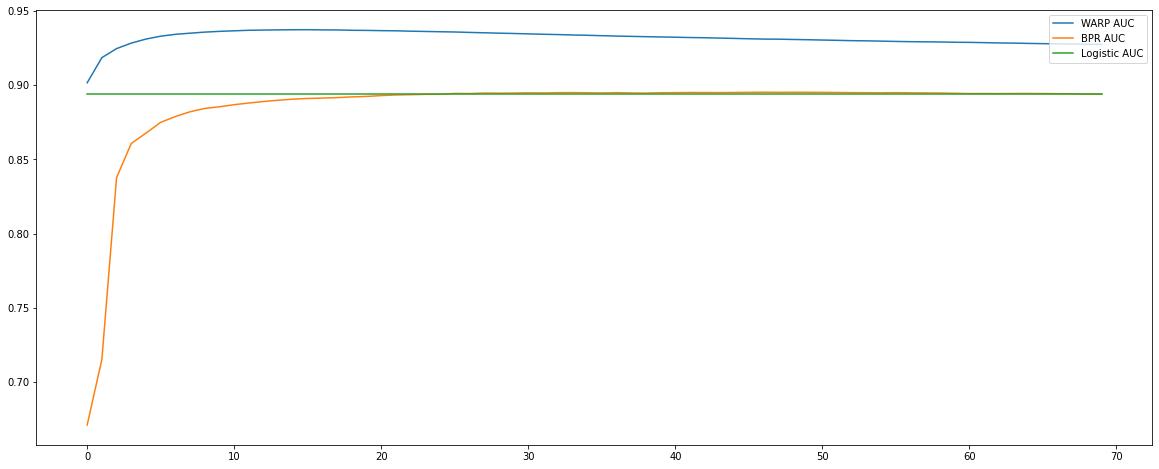

In [13]:
x = np.arange(epochs)
plt.figure(figsize = (20, 8))
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.plot(x, np.array(logistic_auc))
plt.legend(['WARP AUC', 'BPR AUC' , 'Logistic AUC'], loc='upper right') 
plt.show()

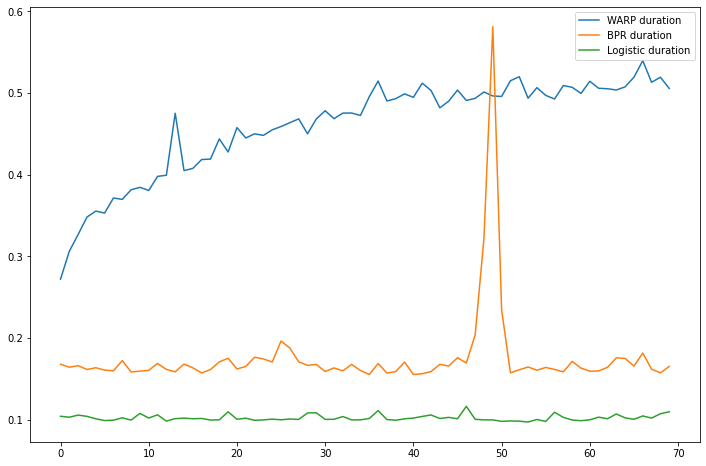

In [14]:
x = np.arange(epochs)
plt.figure(figsize = (12, 8))
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.plot(x, np.array(logistic_duration))
plt.legend(['WARP duration', 'BPR duration', 'Logistic duration'], loc='upper right')
plt.show()

In [15]:
data = fetch_movielens(min_rating=4.0)
train, test = data['train'], data['test']


In [16]:
model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(data['train'], epochs=10)

train_precision = precision_at_k(model, data['train'], k=10).mean()
test_precision = precision_at_k(model, data['test'], k=10).mean()

train_auc = auc_score(model, data['train']).mean()
test_auc = auc_score(model, data['test']).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.50, test 0.07.
AUC: train 0.89, test 0.84.


In [17]:
model = LightFM(learning_rate=0.05, loss='warp')
model.fit_partial(data['train'], epochs=10)

train_precision = precision_at_k(model, data['train'], k=10).mean()
test_precision = precision_at_k(model, data['test'], k=10).mean()

train_auc = auc_score(model, data['train']).mean()
test_auc = auc_score(model, data['test']).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.48, test 0.07.
AUC: train 0.94, test 0.91.


In [18]:
model = LightFM(learning_rate=0.05, loss='logistic')
model.fit_partial(data['train'], epochs=10)

train_precision = precision_at_k(model, data['train'], k=10).mean()
test_precision = precision_at_k(model, data['test'], k=10).mean()

train_auc = auc_score(model, data['train']).mean()
test_auc = auc_score(model, data['test']).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.34, test 0.06.
AUC: train 0.88, test 0.87.


In [19]:
app = Flask(__name__)

In [20]:
@app.route('/')
def recom_for_user():
    user_id = request.args.get('user_id', default = 1, type = int)
    
    n_users, n_items = data['train'].shape
    known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
    scores = model.predict(user_id, np.arange(n_items))
    top_items = data['item_labels'][np.argsort(-scores)][:10]
    
    movie_scores = zip(top_items, scores)
    
    return jsonify(
        movies=[
            {
                "id": i,
                "score": float(s),
            }
            for i, s in movie_scores
        ],
    )

In [23]:
app.run(host="0.0.0.0", port=6000)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:6000/ (Press CTRL+C to quit)


# Новый раздел

In [ ]:
from google.colab import drive
drive.mount('/content/drive')